Cargando dataset desde: E:\Descargas\Proyecto de Minería de Datos – Grupo 4\Online Retail.xlsx
✅ Dataset cargado correctamente
Filas: 541909 | Columnas: 8

--- Limpieza de datos ---
Datos después de limpiar: 397924 registros

--- Calculando variables RFM ---
Primeros datos del RFM:


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40



--- Normalizando variables ---

--- Determinando número óptimo de clústeres (Método del Codo) ---


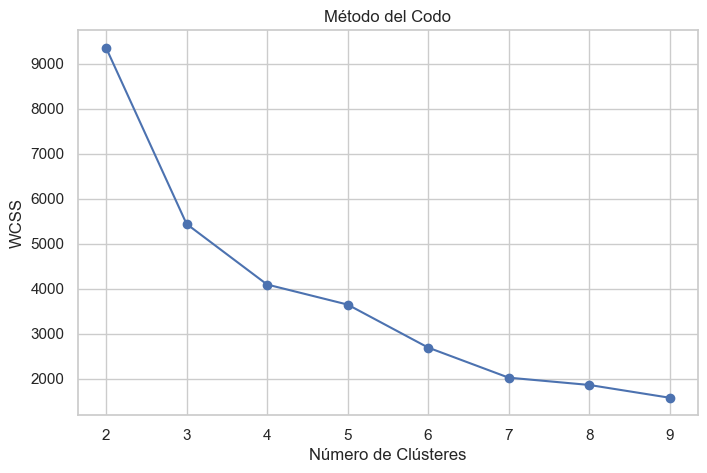


--- Evaluando con Silhouette Score ---
Clusters=2 -> Silhouette Score=0.5605
Clusters=3 -> Silhouette Score=0.5943
Clusters=4 -> Silhouette Score=0.6161
Clusters=5 -> Silhouette Score=0.4363
Clusters=6 -> Silhouette Score=0.4923
Clusters=7 -> Silhouette Score=0.5162
Clusters=8 -> Silhouette Score=0.5169
Clusters=9 -> Silhouette Score=0.4918

--- Entrenando modelo final ---

✅ Modelo guardado en: E:\Descargas\Proyecto de Minería de Datos – Grupo 4\modelo_kmeans.pkl
✅ Resultados guardados en: E:\Descargas\Proyecto de Minería de Datos – Grupo 4\resultados_segmentacion.csv

--- Promedios por clúster ---


,Recency,Frequency,Monetary
Cluster,,,
0,15.67,22.05,12453.23
1,248.56,1.55,478.11
2,7.38,82.69,127338.31
3,43.91,3.66,1349.70



--- Graficando resultados ---


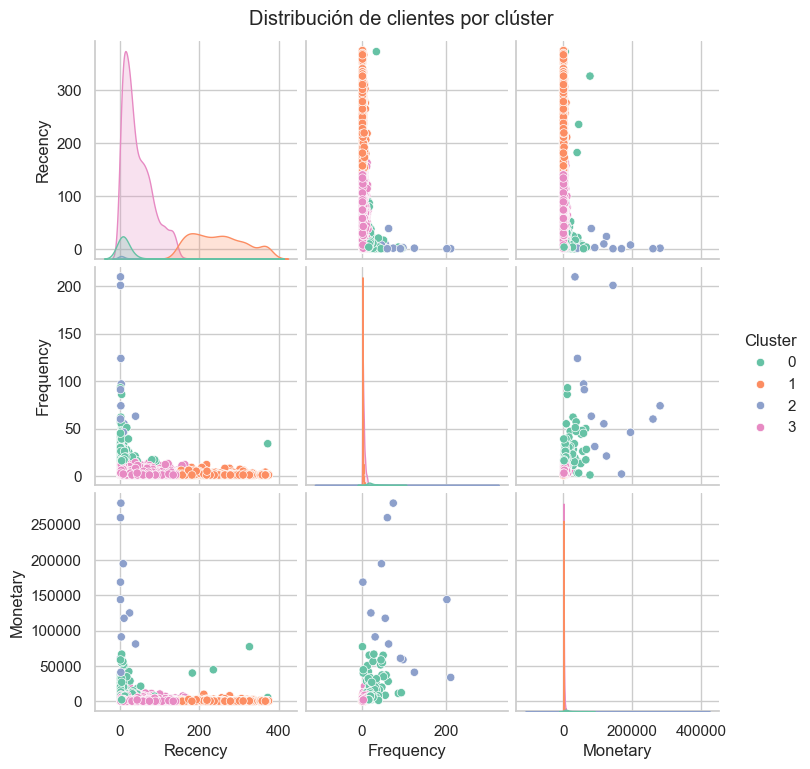


--- Comparando con DBSCAN (opcional) ---
Silhouette Score DBSCAN: 0.8854

🚀 Proceso completado exitosamente.


In [5]:
# ============================================================
# PROYECTO DE MINERÍA DE DATOS – GRUPO 4
# “Clasificación de clientes según patrones de compra”
# ============================================================

# === 1. Importar Librerías ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import joblib
import os

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# === 2. Ruta base del proyecto ===
ruta_base = r"E:\Descargas\Proyecto de Minería de Datos – Grupo 4"
ruta_excel = os.path.join(ruta_base, "Online Retail.xlsx")
print(f"Cargando dataset desde: {ruta_excel}")

df = pd.read_excel(ruta_excel)
print("✅ Dataset cargado correctamente")
print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
df.head()

# === 3. Limpieza y Preparación ===
print("\n--- Limpieza de datos ---")

# Convertir fechas
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Eliminar registros nulos o cancelados
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]

print(f"Datos después de limpiar: {df.shape[0]} registros")

# === 4. Cálculo de Variables RFM ===
print("\n--- Calculando variables RFM ---")

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "UnitPrice": lambda x: (x * df.loc[x.index, "Quantity"]).sum()  # Monetary
}).rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "UnitPrice": "Monetary"
})

print("Primeros datos del RFM:")
display(rfm.head())

# === 5. Normalización ===
print("\n--- Normalizando variables ---")
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

# === 6. Método del Codo ===
print("\n--- Determinando número óptimo de clústeres (Método del Codo) ---")
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, 'bo-')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('WCSS')
plt.show()

# === 7. Silhouette Score ===
print("\n--- Evaluando con Silhouette Score ---")
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"Clusters={k} -> Silhouette Score={score:.4f}")

# === 8. Entrenamiento final con K-Means ===
print("\n--- Entrenando modelo final ---")
k_optimo = 4  # Cambia este valor según los resultados del codo/silhouette
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
rfm["Cluster"] = kmeans_final.fit_predict(rfm_scaled)

# === 9. Guardar modelo y resultados ===
modelo_path = os.path.join(ruta_base, "modelo_kmeans.pkl")
csv_path = os.path.join(ruta_base, "resultados_segmentacion.csv")

joblib.dump(kmeans_final, modelo_path)
rfm.to_csv(csv_path)

print(f"\n✅ Modelo guardado en: {modelo_path}")
print(f"✅ Resultados guardados en: {csv_path}")

# === 10. Resultados ===
print("\n--- Promedios por clúster ---")
cluster_summary = rfm.groupby("Cluster").mean().round(2)
display(cluster_summary)

# === 11. Visualizaciones ===
print("\n--- Graficando resultados ---")
sns.pairplot(rfm, hue="Cluster", palette="Set2")
plt.suptitle("Distribución de clientes por clúster", y=1.02)
plt.show()

# === 12. Comparación opcional con DBSCAN ===
print("\n--- Comparando con DBSCAN (opcional) ---")
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(rfm_scaled)

if len(set(db_labels)) > 1:
    score_db = silhouette_score(rfm_scaled, db_labels)
    print(f"Silhouette Score DBSCAN: {score_db:.4f}")
else:
    print("DBSCAN no formó más de un clúster, ajustar parámetros eps/min_samples.")

print("\n🚀 Proceso completado exitosamente.")
